<a href="https://www.kaggle.com/code/maimunulkjisan/loan-status-prediction-with-catboost-and-shap?scriptVersionId=202656606" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 📚✨ Table of Contents


---

1. **📦 Importing Required Libraries**  
   - Load necessary libraries for data manipulation, preprocessing, and modeling.

2. **📊 Loading the Data**  
   - Read training and test datasets from CSV files.

3. **🔍 Defining Categorical and Numerical Features**  
   - Specify which features are categorical and which are numerical for preprocessing.

4. **🔄 Mapping Categorical Values**  
   - Convert categorical variables to numerical format for modeling.

5. **🗂️ Separating Features and Target Variable**  
   - Distinguish between input features and the target variable (`loan_status`).

6. **⚙️ Creating Preprocessing Steps**  
   - Set up preprocessing steps for numerical and categorical features.

7. **🐱 Defining the CatBoost Classifier**  
   - Configure the CatBoost Classifier with initial hyperparameters.

8. **🔗 Creating a Pipeline**  
   - Combine preprocessing and modeling steps into a single pipeline.

9. **🔧 Setting Up Hyperparameter Grid for Tuning**  
   - Define a grid of hyperparameters to search for the best model.

10. **🔍 Grid Search with Cross-Validation**  
    - Perform grid search with cross-validation to find optimal parameters.

11. **🏋️ Fitting the Model**  
    - Train the model using the training data.

12. **📈 Evaluating Model Performance**  
    - Assess the model's performance on the training data.

13. **🔮 Making Predictions on the Test Set**  
    - Use the trained model to make predictions on the unseen test set.

14. **📋 Creating the Output DataFrame**  
    - Prepare the DataFrame for submission with predictions.

15. **💾 Saving Predictions to CSV**  
    - Export the predictions to a CSV file for submission.

16. **📢 Printing Results**  
    - Display the results of model evaluation and predictions.

---

📝 *Let’s get started!*



<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">One</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;"> Import Required Library 📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import set_config
import matplotlib.pyplot as plt
from catboost import Pool
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shap
from sklearn.model_selection import StratifiedKFold

<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Two</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;"> Loading The Data📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
train.head()


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Three</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;"> Defining Categorical and Numerical Features 📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [3]:
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade']
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Four</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;"> Mapping Categorical Values 📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [4]:
train['cb_person_default_on_file'] = train['cb_person_default_on_file'].map({'N': 0, 'Y': 1})
test['cb_person_default_on_file'] = test['cb_person_default_on_file'].map({'N': 0, 'Y': 1})

<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Five</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;"> Separating Features and Target Variable 📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [5]:
X_train = train.drop('loan_status', axis=1)
y_train = train['loan_status']

<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Six</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;">Creating Preprocessing Steps 📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), 
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features) 
    ])

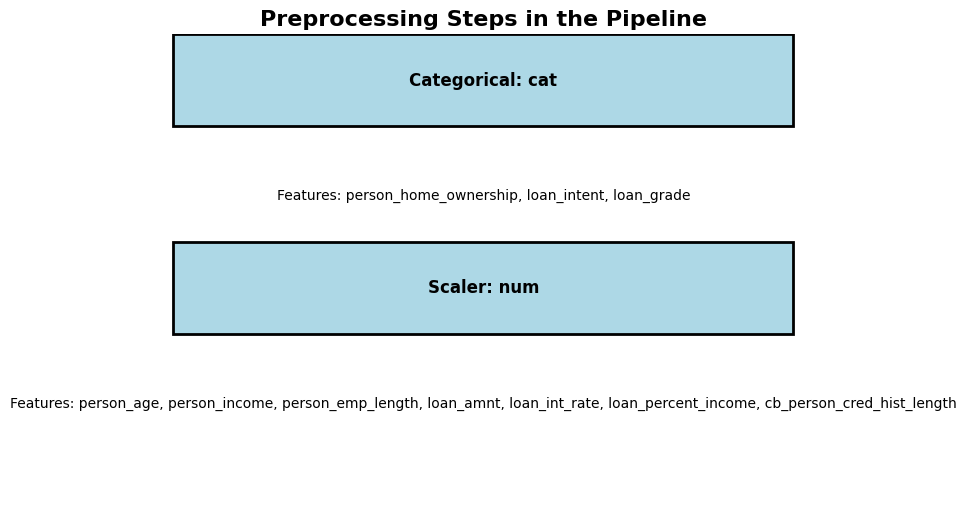

In [7]:


def draw_preprocessing_pipeline(preprocessor):
    fig, ax = plt.subplots(figsize=(10, 6))
    padding = 0.05
    rectangle_height = 0.2

    transformers_order = [
        ('Categorical', 'cat', categorical_features), 
        ('Scaler', 'num', numerical_features)
    ]
    
    for i, (name, transformer, features) in enumerate(transformers_order):
        y_position = 0.8 - i * (rectangle_height + 0.25)
        rect = mpatches.Rectangle((0.1, y_position), 0.8, rectangle_height, edgecolor='black', facecolor='lightblue', lw=2)
        ax.add_patch(rect)
        ax.text(0.5, y_position + rectangle_height / 2, f'{name}: {transformer}', 
                ha='center', va='center', fontsize=12, weight='bold')
        
        features_y_position = y_position - padding - 0.1
        ax.text(0.5, features_y_position, f'Features: {", ".join(features)}', 
                ha='center', va='center', fontsize=10)

    ax.set_title('Preprocessing Steps in the Pipeline', fontsize=16, weight='bold')
    ax.axis('off')

    plt.show()

draw_preprocessing_pipeline(preprocessor)


<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Seven</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;"> Defining the CatBoost Classifier 📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [8]:
catboost_model = CatBoostClassifier(loss_function='Logloss', verbose=100)

<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Eight</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;">Creating a Pipeline📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [9]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', catboost_model)
])

set_config(display='diagram')
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent',
                                                   'loan_grade'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x79f81fceb640>)])

<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Nine</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;"> Setting Up Hyperparameter Grid for Tuning📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [10]:
param_grid = {
    'classifier__iterations': [1000],
    'classifier__depth': [8],            
    'classifier__learning_rate': [0.2],  
    'classifier__l2_leaf_reg': [7]         
}



<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Ten</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;"> Grid Search with Cross-Validation 📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [11]:
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')

grid_search.fit(X_train, y_train) 


Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.4681903	total: 68.7ms	remaining: 1m 8s
100:	learn: 0.1319903	total: 1.64s	remaining: 14.6s
200:	learn: 0.1115334	total: 3.21s	remaining: 12.8s
300:	learn: 0.0972299	total: 4.84s	remaining: 11.3s
400:	learn: 0.0848678	total: 6.47s	remaining: 9.66s
500:	learn: 0.0749218	total: 8.07s	remaining: 8.04s
600:	learn: 0.0663895	total: 9.66s	remaining: 6.41s
700:	learn: 0.0587967	total: 11.3s	remaining: 4.8s
800:	learn: 0.0532066	total: 12.9s	remaining: 3.19s
900:	learn: 0.0482190	total: 14.5s	remaining: 1.59s
999:	learn: 0.0438296	total: 16.1s	remaining: 0us


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['person_age',
                                                                          'person_income',
                                                                          'person_emp_length',
                                                                          'loan_amnt',
                                                                          'loan_int_rate',
                                                                          'loan_percent_income',
                                                                          'cb_person_cred_hist_length']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['person_home_ownership',
                                                                          'loan_intent',
                                                                          'loan_grade'])])),
                                       ('classifier',
                                        <catboost.core.CatBoostClassifier object at 0x79f81fceb640>)]),
             n_jobs=-1,
             param_grid={'classifier__depth': [8],
                         'classifier__iterations': [1000],
                         'classifier__l2_leaf_reg': [7],
                         'classifier__learning_rate': [0.2]},
             scoring='accuracy', verbose=1)

<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Eleven</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;"> Fitting the Model📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [12]:
best_model = grid_search.best_estimator_

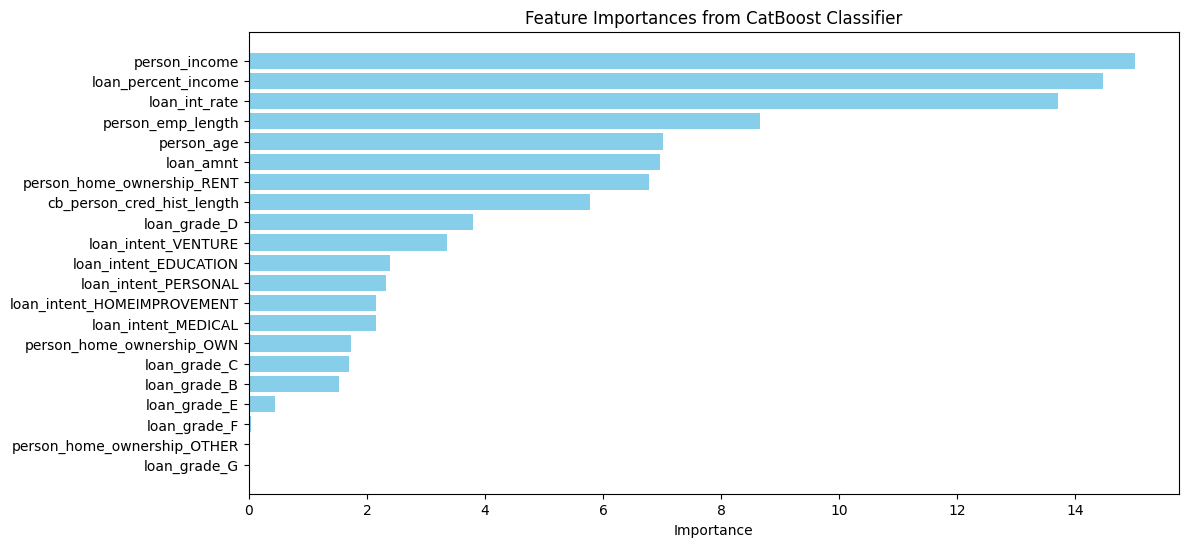

In [13]:
best_model = grid_search.best_estimator_

importances = best_model.named_steps['classifier'].get_feature_importance()

feature_names = best_model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(numerical_features).tolist() + \
                best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features).tolist()

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from CatBoost Classifier')
plt.gca().invert_yaxis()
plt.show()

<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Twelve</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;">Evaluating Model Performance 📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [14]:
train_accuracy = best_model.score(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Training Accuracy:", train_accuracy)

Best Parameters: {'classifier__depth': 8, 'classifier__iterations': 1000, 'classifier__l2_leaf_reg': 7, 'classifier__learning_rate': 0.2}
Training Accuracy: 0.989052775172649


<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Thirteen</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;">Making Predictions on the Test Set 📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [15]:
predicted_probabilities = best_model.predict_proba(test)[:, 1]  

<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Fourteen</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;"> Creating the Output DataFrame 📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [16]:
output = pd.DataFrame({'id': test['id'], 'loan_status': predicted_probabilities})

<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Fifteen</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;"> Saving Predictions to CSV 📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [17]:

output.to_csv('loan_predictions.csv', index=False)



<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Sixteen</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;"> Printing Results 📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

In [18]:
print("Predictions saved to 'loan_predictions.csv'")

Predictions saved to 'loan_predictions.csv'


In [19]:
pd.read_csv('loan_predictions.csv')

,id,loan_status
0,58645,0.999725
1,58646,0.019717
2,58647,0.976998
3,58648,0.005981
4,58649,0.040090
...,...,...
39093,97738,0.008069
39094,97739,0.000496
39095,97740,0.002172
39096,97741,0.624242


<div style="background-color: #48cae4; border-radius: 15px; padding: 20px; text-align: left;">
    <h1 style="margin: 0;">
        <b>
            <span style="color: Black;">Seventeen</span>
            <span style="color: #ffffff;">|</span>
            <span style="color: #FEEC37;"> Shap 📊
            </span>
        </b>
    </h1>
    <br>
    <a href="#table-of-contents" style="font-family: Arial, sans-serif; font-size: 20px; background-color: #7b2cbf; color: #ffffff; padding: 7px 15px; text-decoration: none; border-radius: 15px;">
        [Table of Content 📜⬆️]
    </a>
</div>

(39098, 21)
[[-0.75430679  0.13060176 -0.42957619  2.83665069  1.67468729  2.18955472
  -0.94648871  0.          0.          1.          0.          1.
   0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [-0.2570553   0.84242465  0.32804728  0.14063214  0.65975036 -0.64605585
  -0.45010755  0.          0.          0.          0.          0.
   0.          1.          0.          0.          1.          0.
   0.          0.          0.        ]
 [-0.2570553  -0.89758686  0.07550612 -0.93777528  2.14590801 -0.31887001
  -0.94648871  0.          0.          1.          0.          0.
   0.          0.          1.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.9031982  -0.37031064 -0.17703503 -0.39857157 -0.58585405 -0.20980807
   0.29446419  0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [-0.257

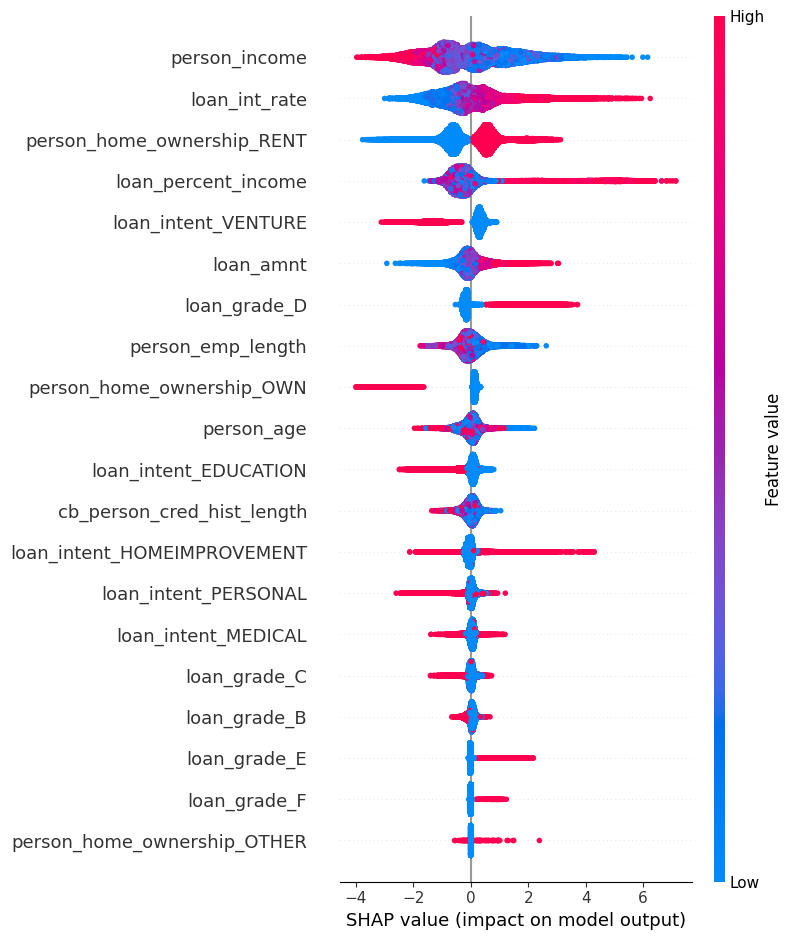

In [20]:
preprocessor.fit(X_train)

X_test_encoded = preprocessor.transform(test)

print(X_test_encoded.shape)
print(X_test_encoded[:5])

feature_names = (
    preprocessor.named_transformers_['num'].get_feature_names_out(numerical_features).tolist() +
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
)

cat_features_indices = [feature_names.index(c) for c in categorical_features if c in feature_names]

X_test_pool = Pool(data=X_test_encoded, cat_features=cat_features_indices)

explainer = shap.TreeExplainer(best_model.named_steps['classifier'])

shap_values = explainer.shap_values(X_test_pool)

shap.summary_plot(shap_values, X_test_encoded, feature_names=feature_names)
